In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
import numpy as np

class SVRGClassifier:
    def __init__(self, loss="log", lr=0.01, max_outer=20, m_inner=1000, tol=1e-5, verbose=0):
        self.loss = loss
        self.lr = lr
        self.max_outer = max_outer
        self.m_inner = m_inner
        self.tol = tol
        self.verbose = verbose
        self.w = None
        self.bias = 0
        self.losses_ = []

    def _compute_loss(self, X, y):
        pred = X @ self.w + self.bias
        if self.loss == "log":
            z = y * pred
            return np.mean(np.log(1 + np.exp(-z)))
        else:
            return np.mean((y - pred) ** 2)

    def _grad_sample_params(self, xi, yi, w, b):
        pred = xi @ w + b
        if self.loss == "log":
            z = yi * pred
            coeff = -yi / (1 + np.exp(z))
        else:
            coeff = pred - yi
        return coeff * xi, coeff

    def _full_grad(self, X, y):
        pred = X @ self.w + self.bias

        if self.loss == "log":
            z = y * pred
            coeff = -y / (1 + np.exp(z))   # shape (n,)
        else:
            coeff = pred - y               # shape (n,)

        grad_w = X.T @ coeff / len(X)
        grad_b = np.mean(coeff)
        return grad_w, grad_b

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Convert labels once
        if self.loss == "log":
            y = 2*y - 1   # convert to ±1

        # Initialize
        self.w = np.random.randn(n_features) * 0.01
        self.bias = 0

        for outer in range(self.max_outer):
            w_tilde = self.w.copy()
            b_tilde = self.bias

            # vectorized full gradient
            grad_full_w, grad_full_b = self._full_grad(X, y)

            w = w_tilde.copy()
            b = b_tilde

            # inner loop
            for _ in range(self.m_inner):
                i = np.random.randint(0, n_samples)

                gw, gb = self._grad_sample_params(X[i], y[i], w, b)
                gw_t, gb_t = self._grad_sample_params(X[i], y[i], w_tilde, b_tilde)
                
                w -= self.lr * (gw - gw_t + grad_full_w)
                b -= self.lr * (gb - gb_t + grad_full_b)

            self.w, self.bias = w, b

            # monitor loss
            loss = self._compute_loss(X, y)
            self.losses_.append(loss)

            if self.verbose:
                print(f"outer={outer+1}, loss={loss:.6f}")

            if outer > 0 and abs(self.losses_[-2] - self.losses_[-1]) < self.tol:
                break

        return self

    def predict_proba(self, X):
        pred = X @ self.w + self.bias
    
        if self.loss == "log":
            p = 1 / (1 + np.exp(-pred))
            return np.stack([1-p, p], axis=1)
    
        p = 1 / (1 + np.exp(-pred))
        return np.stack([1-p, p], axis=1)


    def predict(self, X):
        return (X @ self.w + self.bias >= 0).astype(int)



In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

In [4]:
# Fetch dataset
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = (bank_marketing.data.targets == "yes").astype(int)  # convert yes/no -> 1/0

# One-hot encode categorical features
X = pd.get_dummies(X)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values.ravel(), test_size=0.2, random_state=42
)


In [5]:
classifier = SVRGClassifier(loss="squared", lr=1e-4, verbose=0)
classifier.fit(X_train, y_train)

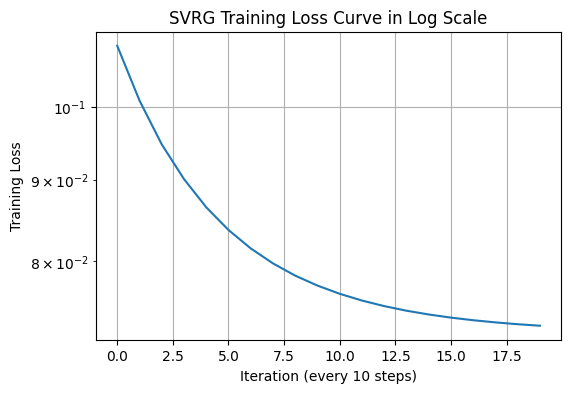

In [6]:
plt.figure(figsize=(6,4))
plt.plot(classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("SVRG Training Loss Curve in Log Scale")
plt.yscale('log')
plt.grid(True)
plt.show()

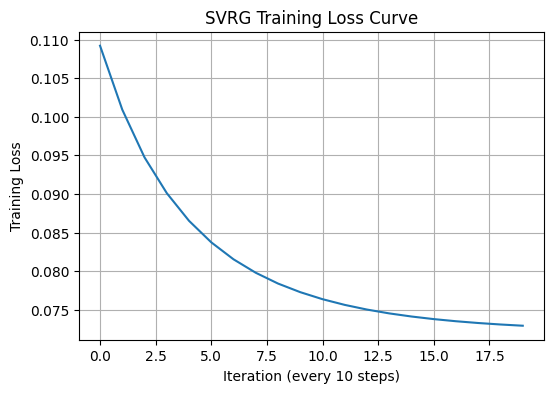

In [7]:
plt.figure(figsize=(6,4))
plt.plot(classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("SVRG Training Loss Curve")
#plt.yscale('log')
plt.grid(True)
plt.show()

In [8]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.35751409930332856


In [9]:
test_loss = classifier._compute_loss(X_test, y_test)
print("Test Loss:", test_loss)

Test Loss: 0.07460938320084376


In [10]:
classifier.losses_

[np.float64(0.10919708629622633),
 np.float64(0.10091260867205074),
 np.float64(0.09472935845154842),
 np.float64(0.09010091650946991),
 np.float64(0.0865126912953595),
 np.float64(0.08372459906336621),
 np.float64(0.08152753647253497),
 np.float64(0.07978376006982801),
 np.float64(0.07838677529637611),
 np.float64(0.07727103797690774),
 np.float64(0.07636189607715273),
 np.float64(0.07562245924476452),
 np.float64(0.07501702214213385),
 np.float64(0.07452069152933267),
 np.float64(0.07411696201149212),
 np.float64(0.07378152850421762),
 np.float64(0.07350509398043263),
 np.float64(0.07327517148215724),
 np.float64(0.07308402237644761),
 np.float64(0.07292452668690227)]